In [88]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import talib
import pandas_datareader.data as web
from statsmodels.regression.rolling import RollingOLS
import statsmodels.api as sm
from sklearn.feature_selection import mutual_info_regression
import lightgbm as lgb
from scipy.stats import spearmanr
from time import time
import shap
from alphalens.tears import (create_returns_tear_sheet,
                             create_summary_tear_sheet,
                             create_full_tear_sheet)

from alphalens import plotting
from alphalens import performance as perf
from alphalens import utils

In [2]:
DATA_STORE = Path('..', 'data', 'stock_prices.h5')

In [54]:
MONTH = 21
YEAR = 252

In [3]:
idx = pd.IndexSlice

In [4]:
with pd.HDFStore(DATA_STORE) as store:
    data = (store['us_stocks']
            .loc[idx[:, '2006':'2016'], :]
            .unstack('ticker')
            .sort_index()
            .fillna(method='ffill', limit=5)
            .stack('ticker')
            .swaplevel()
            .dropna()
            .sort_index())

In [5]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 3,186 | # Dates: 2,846


In [6]:
top200 = data.close.mul(data.volume).unstack('ticker').dropna(thresh=8*252,axis=1).mean().nlargest(200)

In [7]:
to_drop = data.index.unique('ticker').difference(top200.index)

In [8]:
data = data.drop(to_drop, level='ticker')

In [9]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 563123 entries, ('AAL', Timestamp('2006-01-03 00:00:00')) to ('YHOO', Timestamp('2016-12-30 00:00:00'))
Data columns (total 5 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    563123 non-null  float64
 1   high    563123 non-null  float64
 2   low     563123 non-null  float64
 3   close   563123 non-null  float64
 4   volume  563123 non-null  float64
dtypes: float64(5)
memory usage: 23.7+ MB


In [10]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 200 | # Dates: 2,845


In [11]:
daily_returns = data.groupby('ticker').close.pct_change()

In [12]:
daily_returns

ticker  date      
AAL     2006-01-03         NaN
        2006-01-04    0.046729
        2006-01-05    0.013010
        2006-01-06   -0.017880
        2006-01-09   -0.010000
                        ...   
YHOO    2016-12-23    0.004156
        2016-12-27    0.006725
        2016-12-28   -0.004882
        2016-12-29   -0.002324
        2016-12-30    0.000776
Name: close, Length: 563123, dtype: float64

In [13]:
outliers = daily_returns[(daily_returns < -1) | (daily_returns > 1)]

In [14]:
outliers

ticker  date      
DELL    2014-04-16    1.258297
HIG     2008-12-05    1.023578
Name: close, dtype: float64

In [15]:
data = data.drop(outliers.index.unique('ticker'), level='ticker')

In [16]:
print(f"# Tickers: {len(data.index.unique('ticker')):,.0f} | # Dates: {len(data.index.unique('date')):,.0f}")

# Tickers: 198 | # Dates: 2,845


In [17]:
by_ticker = data.groupby(level='ticker')

In [18]:
T = [1, 3, 5, 10, 21, 42, 63, 126, 252]

In [19]:
for t in T:
    data[f'ret_{t:02}'] = by_ticker.close.pct_change(t)

In [20]:
data.head()

open        high         low       close  \
ticker date                                                         
AAL    2006-01-03   96.658326   99.464536   95.748907   97.307912   
       2006-01-04   97.957497  105.492689   97.957497  101.855011   
       2006-01-05  101.803044  103.180165  101.101491  103.180165   
       2006-01-06  103.180165  103.180165   99.100768  101.335342   
       2006-01-09  100.815674  101.023541  100.036171  100.321989   

                        volume    ret_01    ret_03  ret_05  ret_10  ret_21  \
ticker date                                                                  
AAL    2006-01-03  1013200.042       NaN       NaN     NaN     NaN     NaN   
       2006-01-04  1928399.929  0.046729       NaN     NaN     NaN     NaN   
       2006-01-05   317900.067  0.013010       NaN     NaN     NaN     NaN   
       2006-01-06   349199.989 -0.017880  0.041389     NaN     NaN     NaN   
       2006-01-09   220799.961 -0.010000 -0.015051     NaN     NaN     NaN   

                   ret_42  ret_63  ret_126  ret_252  
ticker date                                          
AAL    2006-01-03     NaN     NaN      NaN      NaN  
       2006-01-04     NaN     NaN      NaN      NaN  
       2006-01-05     NaN     NaN      NaN      NaN  
       2006-01-06     NaN     NaN      NaN      NaN  
       2006-01-09     NaN     NaN      NaN      NaN

In [21]:
def compute_bb_indicators(close, timeperiod=20, matype=0):
    high, mid, low = talib.BBANDS(close, 
                                  timeperiod=20,
                                  matype=matype)
    bb_up = high / close -1
    bb_low = low / close -1
    squeeze = (high - low) / close
    return pd.DataFrame({'BB_UP': bb_up, 
                         'BB_LOW': bb_low, 
                         'BB_SQUEEZE': squeeze}, 
                        index=close.index)

In [22]:
data = (data.join(data
                  .groupby(level='ticker')
                  .close
                  .apply(compute_bb_indicators)))

In [23]:
def compute_adx(x, timeperiod=14):
    return talib.ADX(x.high, 
                    x.low,
                    x.close,
                    timeperiod=timeperiod)

In [24]:
data['ADX'] = (data.groupby(level='ticker', group_keys=False)
                  .apply(compute_adx))

In [25]:
def compute_macd(close, fastperiod=12, slowperiod=26, signalperiod=9):
    macd, macdsignal, macdhist = talib.MACD(close,
                                            fastperiod=fastperiod,
                                            slowperiod=slowperiod,
                                            signalperiod=signalperiod)
    return pd.DataFrame({'MACD': macd,
                         'MACD_SIGNAL': macdsignal,
                         'MACD_HIST': macdhist},
                        index=close.index)

In [26]:
data = (data.join(data
                  .groupby(level='ticker')
                  .close
                  .apply(compute_macd)))

In [27]:
data['RSI'] = (data.groupby(level='ticker', group_keys=False)
               .apply(lambda x: talib.RSI(x.close,
                                          timeperiod=14)))

In [28]:
data.tail()

open    high    low  close     volume    ret_01    ret_03  \
ticker date                                                                     
YHOO   2016-12-23  38.46  38.810  38.37  38.66  3841245.0  0.004156 -0.012768   
       2016-12-27  38.59  39.065  38.50  38.92  4240285.0  0.006725 -0.005875   
       2016-12-28  39.12  39.220  38.71  38.73  4428368.0 -0.004882  0.005974   
       2016-12-29  38.76  38.930  38.48  38.64  4170497.0 -0.002324 -0.000517   
       2016-12-30  38.72  39.000  38.43  38.67  6432792.0  0.000776 -0.006423   

                     ret_05    ret_10    ret_21  ...   ret_126   ret_252  \
ticker date                                      ...                       
YHOO   2016-12-23  0.001295 -0.074234 -0.056152  ...  0.097672  0.133392   
       2016-12-27  0.013014 -0.057627 -0.047712  ...  0.079911  0.158333   
       2016-12-28 -0.010981 -0.066072 -0.065621  ...  0.050733  0.137779   
       2016-12-29 -0.013027 -0.055488 -0.071154  ...  0.028754  0.157926   
       2016-12-30  0.004416  0.006769 -0.057289  ...  0.017899  0.162658   

                      BB_UP    BB_LOW  BB_SQUEEZE        ADX      MACD  \
ticker date                                                              
YHOO   2016-12-23  0.098858 -0.023793    0.122651  21.877612 -0.635354   
       2016-12-27  0.087510 -0.032808    0.120317  22.369276 -0.628648   
       2016-12-28  0.087521 -0.030150    0.117671  22.558674 -0.631387   
       2016-12-29  0.086712 -0.030708    0.117419  22.972109 -0.633516   
       2016-12-30  0.085815 -0.033888    0.119703  23.224638 -0.625573   

                   MACD_SIGNAL  MACD_HIST        RSI  
ticker date                                           
YHOO   2016-12-23    -0.459653  -0.175701  38.902592  
       2016-12-27    -0.493452  -0.135196  41.265196  
       2016-12-28    -0.521039  -0.110348  40.046494  
       2016-12-29    -0.543534  -0.089982  39.452123  
       2016-12-30    -0.559942  -0.065631  39.773007  

[5 rows x 22 columns]

In [29]:
data['BOP'] = (data.groupby(level='ticker', group_keys=False)
               .apply(lambda x: talib.BOP(x.open,
                                          x.high,
                                          x.low,
                                          x.close)))

In [30]:
data['MFI'] = (data.groupby(level='ticker', group_keys=False)
               .apply(lambda x: talib.MFI(x.high,
                                          x.low,
                                          x.close,
                                          x.volume,
                                          timeperiod=14)))

In [31]:
data['ADOSC'] = (data.groupby(level='ticker', group_keys=False)
                .apply(lambda x: talib.ADOSC(x.high, x.low,
                                            x.close,
                                            x.volume,
                                            fastperiod=3,
                                            slowperiod=10)/x.rolling(14).volume.mean()))

In [32]:
data['NATR'] = (data.groupby(level='ticker', group_keys=False)
                .apply(lambda x: talib.NATR(x.high,x.low,x.close,timeperiod=14)))

In [33]:
factor_data = (web.DataReader('F-F_Research_Data_5_Factors_2x3_daily', 'famafrench', 
                              start=1998)[0].rename(columns={'Mkt-RF': 'MARKET'}))
factor_data.index.names = ['date']

In [34]:
factor_data

MARKET   SMB   HML   RMW   CMA     RF
date                                             
1998-01-02    0.22 -0.12 -0.49  0.20 -0.14  0.021
1998-01-05    0.22  0.06 -0.29  0.03 -0.01  0.021
1998-01-06   -1.04  0.24  0.20 -0.38  0.14  0.021
1998-01-07   -0.38 -0.38 -0.22 -0.12  0.33  0.021
1998-01-08   -0.82  0.18 -0.09  0.05  0.29  0.021
...            ...   ...   ...   ...   ...    ...
2020-10-26   -1.85 -0.45 -0.40 -0.04  0.05  0.000
2020-10-27   -0.23 -0.58 -2.38 -0.27 -0.73  0.000
2020-10-28   -3.42  0.22  0.55 -0.49  0.01  0.000
2020-10-29    1.13  0.14  0.23  0.23  0.57  0.000
2020-10-30   -1.45 -0.24  1.87  0.25  0.00  0.000

[5746 rows x 6 columns]

In [35]:
factor_data.shape

(5746, 6)

In [36]:
factors = factor_data.columns[:-1]
factors

Index(['MARKET', 'SMB', 'HML', 'RMW', 'CMA'], dtype='object')

In [37]:
t = 1
ret = f'ret_{t:02}'
windows = [63, 252]

In [38]:
for window in windows:
    print(window)
    betas = []
    for ticker, df in data.groupby('ticker', group_keys=False):
        model_data = df[[ret]].merge(factor_data, on='date').dropna()
        model_data[ret] -= model_data.RF

        rolling_ols = RollingOLS(endog=model_data[ret], 
                                 exog=sm.add_constant(model_data[factors]), window=window)
        factor_model = rolling_ols.fit(params_only=True).params.rename(columns={'const':'ALPHA'})
        result = factor_model.assign(ticker=ticker).set_index('ticker', append=True).swaplevel()
        betas.append(result)
    betas = pd.concat(betas).rename(columns=lambda x: f'{x}_{window:02}')
    data = data.join(betas)

63
252


In [39]:
data['ret_fwd'] = data.groupby('ticker', group_keys=False).ret_01.shift(-1)
data = data.dropna(subset=['ret_fwd'])

In [40]:
data = (data
        .drop(['open', 'high', 'low', 'close', 'volume'], axis=1)
        .replace((np.inf, -np.inf), np.nan))

In [41]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 557952 entries, ('AAL', Timestamp('2006-01-03 00:00:00')) to ('YHOO', Timestamp('2016-12-29 00:00:00'))
Data columns (total 34 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   ret_01       557754 non-null  float64
 1   ret_03       557358 non-null  float64
 2   ret_05       556962 non-null  float64
 3   ret_10       555972 non-null  float64
 4   ret_21       553794 non-null  float64
 5   ret_42       549636 non-null  float64
 6   ret_63       545478 non-null  float64
 7   ret_126      533004 non-null  float64
 8   ret_252      508056 non-null  float64
 9   BB_UP        554190 non-null  float64
 10  BB_LOW       554190 non-null  float64
 11  BB_SQUEEZE   554190 non-null  float64
 12  ADX          552606 non-null  float64
 13  MACD         551418 non-null  float64
 14  MACD_SIGNAL  551418 non-null  float64
 15  MACD_HIST    551418 non-null  float64
 16  RSI          555180 non-null  floa

In [42]:
with pd.HDFStore('../data/stock_prices.h5') as store:
    store.put('model_data', data)

In [43]:
fwd_returns = data.filter(like='fwd').columns
features = data.columns.difference(fwd_returns).tolist()

In [44]:
features

['ADOSC',
 'ADX',
 'ALPHA_252',
 'ALPHA_63',
 'BB_LOW',
 'BB_SQUEEZE',
 'BB_UP',
 'BOP',
 'CMA_252',
 'CMA_63',
 'HML_252',
 'HML_63',
 'MACD',
 'MACD_HIST',
 'MACD_SIGNAL',
 'MARKET_252',
 'MARKET_63',
 'MFI',
 'NATR',
 'RMW_252',
 'RMW_63',
 'RSI',
 'SMB_252',
 'SMB_63',
 'ret_01',
 'ret_03',
 'ret_05',
 'ret_10',
 'ret_126',
 'ret_21',
 'ret_252',
 'ret_42',
 'ret_63']

In [45]:
fwd_corr = data.drop(['ret_fwd'], axis=1).corrwith(data.ret_fwd, method='spearman')

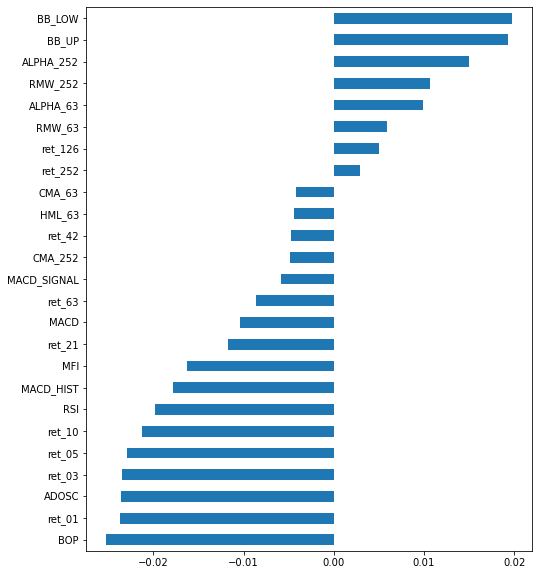

In [46]:
top50 = fwd_corr.abs().nlargest(25).index
fwd_corr.loc[top50].sort_values().plot.barh(figsize=(8, 10),
                                            legend=False);

In [47]:
mi = {}
for feature in features:
    print(feature)
    df = (data
          .loc[:, ['ret_fwd', feature]]
          .dropna()
          .sample(n=1000))
    discrete_features = df[feature].nunique() < 20
    mi[feature] = mutual_info_regression(X=df[[feature]],
                                         y=df.ret_fwd,
                                         discrete_features=discrete_features)[0]

ADOSC
ADX
ALPHA_252
ALPHA_63
BB_LOW
BB_SQUEEZE
BB_UP
BOP
CMA_252
CMA_63
HML_252
HML_63
MACD
MACD_HIST
MACD_SIGNAL
MARKET_252
MARKET_63
MFI
NATR
RMW_252
RMW_63
RSI
SMB_252
SMB_63
ret_01
ret_03
ret_05
ret_10
ret_126
ret_21
ret_252
ret_42
ret_63


In [48]:
mi = pd.Series(mi)

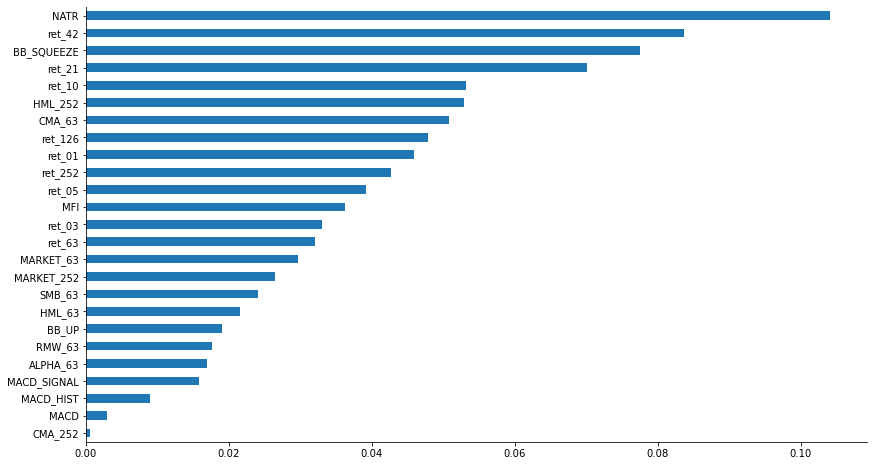

In [49]:
mi.nlargest(25).sort_values().plot.barh(figsize=(14,8))
sns.despine();

In [50]:
class MultipleTimeSeriesCV:
    """Generates tuples of train_idx, test_idx pairs
    Assumes the MultiIndex contains levels 'symbol' and 'date'
    purges overlapping outcomes"""

    def __init__(self,
                 n_splits=3,
                 train_period_length=126,
                 test_period_length=21,
                 lookahead=None,
                 date_idx='date',
                 shuffle=False):
        self.n_splits = n_splits
        self.lookahead = lookahead
        self.test_length = test_period_length
        self.train_length = train_period_length
        self.shuffle = shuffle
        self.date_idx = date_idx

    def split(self, X, y=None, groups=None):
        unique_dates = X.index.get_level_values(self.date_idx).unique()
        days = sorted(unique_dates, reverse=True)
        split_idx = []
        for i in range(self.n_splits):
            test_end_idx = i * self.test_length
            test_start_idx = test_end_idx + self.test_length
            train_end_idx = test_start_idx + self.lookahead - 1
            train_start_idx = train_end_idx + self.train_length + self.lookahead - 1
            split_idx.append([train_start_idx, train_end_idx,
                              test_start_idx, test_end_idx])

        dates = X.reset_index()[[self.date_idx]]
        for train_start, train_end, test_start, test_end in split_idx:

            train_idx = dates[(dates[self.date_idx] > days[train_start])
                              & (dates.date <= days[train_end])].index
            test_idx = dates[(dates.date > days[test_start])
                             & (dates.date <= days[test_end])].index
            if self.shuffle:
                np.random.shuffle(list(train_idx))
            yield train_idx.to_numpy(), test_idx.to_numpy()

    def get_n_splits(self, X, y, groups=None):
        return self.n_splits

In [51]:
def get_fi(model):
    fi = model.feature_importance(importance_type='gain')
    return (pd.Series(fi / fi.sum(),
                      index=model.feature_name()))

In [52]:
def ic_lgbm(preds, train_data):
    """Custom IC eval metric for lightgbm"""
    is_higher_better = True
    return 'ic', spearmanr(preds, train_data.get_label())[0], is_higher_better

In [57]:
train_length = 9 * YEAR
test_length = YEAR
n_splits = 1

In [58]:
params = dict(boosting='gbdt',
              objective='regression',
              verbose=-1,
              learning_rate=0.01,
              #device='gpu', # uncomment if using GPU
              #max_bins=63,  # uncomment if using GPU
              metric='None')

In [59]:
num_boost_round = 5000

In [61]:
lgb_data = lgb.Dataset(data=data.loc[:, features],
                       label=data[fwd_returns],
                       #categorical_feature=categoricals,
                       free_raw_data=False)

In [62]:
cv = MultipleTimeSeriesCV(n_splits=n_splits,
                          lookahead=1,
                          test_period_length=test_length,
                          train_period_length=train_length)

In [65]:
for train_idx, test_idx in cv.split(X=data):
    start = time()
    lgb_train = lgb_data.subset(train_idx.tolist()).construct()
    lgb_test = lgb_data.subset(test_idx.tolist()).construct()
    evals_result = {}
    model = lgb.train(params=params,
                      train_set=lgb_train,
                      num_boost_round=num_boost_round,
                      valid_sets=[lgb_train, lgb_test],
                      valid_names=['train', 'valid'],
                      feval=ic_lgbm,
                      evals_result=evals_result,
                      early_stopping_rounds=500,
                      verbose_eval=100)
    model.save_model('lgb_model.txt')

Training until validation scores don't improve for 500 rounds
[100]	train's ic: 0.0538463	valid's ic: 0.0128559
[200]	train's ic: 0.0629251	valid's ic: 0.0331955
[300]	train's ic: 0.0727186	valid's ic: 0.0338278
[400]	train's ic: 0.0825034	valid's ic: 0.0350943
[500]	train's ic: 0.0903044	valid's ic: 0.0353127
[600]	train's ic: 0.0975585	valid's ic: 0.0357328
[700]	train's ic: 0.104209	valid's ic: 0.0372674
Early stopping, best iteration is:
[236]	train's ic: 0.0658983	valid's ic: 0.0380196


In [66]:
model = lgb.Booster(model_file='lgb_model.txt')

In [67]:
test_set = data.iloc[test_idx, :]
X_test = test_set.loc[:, model.feature_name()]
y_test = test_set.loc[:, fwd_returns[0]]
y_pred = model.predict(X_test)
cv_preds = y_test.to_frame('y_test').assign(y_pred=y_pred)
by_day = cv_preds.groupby(level='date')
ic_by_day = by_day.apply(lambda x: spearmanr(x.y_test, x.y_pred)[0])
daily_ic_mean = ic_by_day.mean()
daily_ic_std = ic_by_day.std()
daily_ic_median = ic_by_day.median()
ic = spearmanr(cv_preds.y_test, cv_preds.y_pred)[0]
print(f'{ic:6.2%} | {daily_ic_mean: 6.2%} | {daily_ic_std/daily_ic_mean: 5.2} | {daily_ic_median: 6.2%}')

 3.80% |  2.57% |   6.0 |  2.11%


In [68]:
fi = get_fi(model)

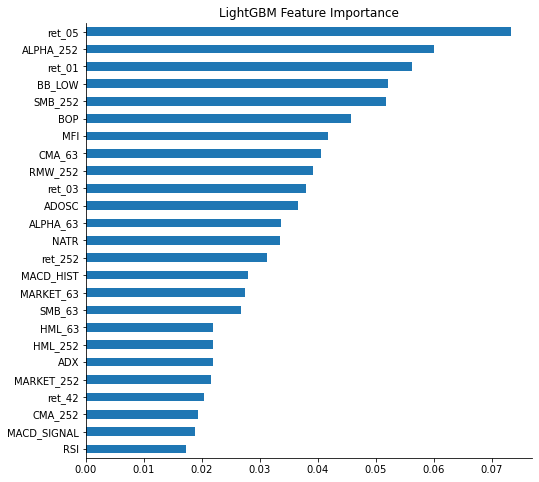

In [69]:
fi.nlargest(25).sort_values().plot.barh(figsize=(8, 8),
                                        title='LightGBM Feature Importance')
sns.despine();

In [72]:
shap.initjs()

In [73]:
model = lgb.Booster(model_file='lgb_model.txt')

In [74]:
explainer = shap.TreeExplainer(model)

Setting feature_perturbation = "tree_path_dependent" because no background data was given.


In [75]:
shap.__version__

'0.35.0'

In [76]:
# workaround for SHAP version 0.35: https://github.com/slundberg/shap/issues/794
model.params['objective'] = 'regression'

In [77]:
shap_values = explainer.shap_values(data.iloc[test_idx, :].loc[:, model.feature_name()])

In [78]:
np.save('shap_values.npy', shap_values)

In [79]:
shap_values = np.load('shap_values.npy')

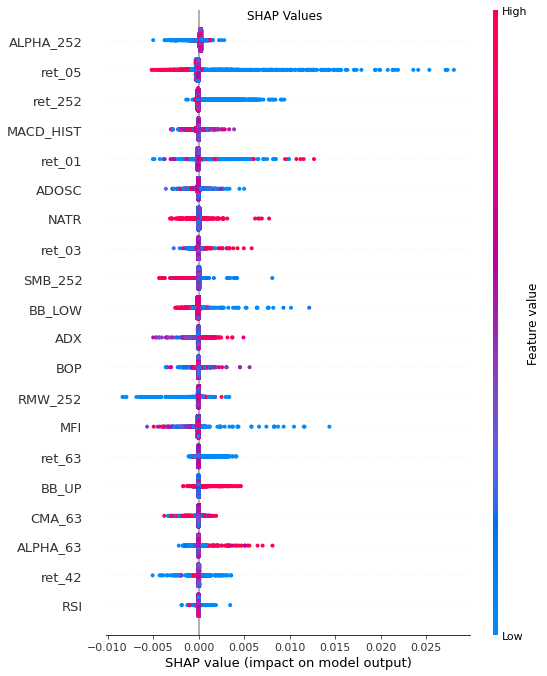

In [80]:
shap.summary_plot(shap_values,
                  data
                  .iloc[test_idx, :]
                  .loc[:, model.feature_name()],
                  show=False)

plt.gcf().suptitle('SHAP Values')
plt.gcf().tight_layout()

In [81]:
shap_values = pd.DataFrame(shap_values, columns=features)

In [82]:
shap_summary = np.abs(shap_values).mean()
shap_summary /= shap_summary.sum()

In [83]:
shap_summary.nlargest(20)

ALPHA_252    0.221431
ret_05       0.129390
ret_252      0.109184
MACD_HIST    0.071231
ret_01       0.055831
ADOSC        0.052843
NATR         0.032441
ret_03       0.027388
SMB_252      0.023972
BB_LOW       0.022019
ADX          0.020607
BOP          0.020137
RMW_252      0.019523
MFI          0.018872
ret_63       0.017790
BB_UP        0.017007
CMA_63       0.015910
ALPHA_63     0.015347
ret_42       0.015285
RSI          0.010268
dtype: float64

In [84]:
tickers = data.index.unique('ticker')

In [85]:
def get_trade_prices(tickers):
    return (pd.read_hdf(DATA_STORE, 'us_stocks')
            .loc[idx[tickers, '2006':'2017'], 'open']
            .unstack('ticker')
            .sort_index()
            .shift(-1)
            .tz_localize('UTC'))

In [86]:
trade_prices = get_trade_prices(tickers)

In [87]:
trade_prices.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3020 entries, 2006-01-03 00:00:00+00:00 to 2017-12-29 00:00:00+00:00
Columns: 198 entries, AAL to YHOO
dtypes: float64(198)
memory usage: 4.6 MB


In [91]:
alpha = 'ALPHA_252'

In [92]:
factor = (data[alpha]
          .unstack('ticker')
          .stack()
          .tz_localize('UTC', level='date')
          .sort_index())

In [93]:
factor_data = utils.get_clean_factor_and_forward_returns(factor=factor,
                                                   prices=trade_prices,
                                                   quantiles=5,
                                                   max_loss=0.35,
                                                   periods=(1, 5, 10)).sort_index()
factor_data.info()

Dropped 0.0% entries from factor data: 0.0% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 35.0%, not exceeded: OK!
<class 'pandas.core.frame.DataFrame'>
MultiIndex: 493094 entries, (Timestamp('2007-01-04 00:00:00+0000', tz='UTC'), 'AAL') to (Timestamp('2016-12-29 00:00:00+0000', tz='UTC'), 'YHOO')
Data columns (total 5 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   1D               493094 non-null  float64
 1   5D               493094 non-null  float64
 2   11D              493094 non-null  float64
 3   factor           493094 non-null  float64
 4   factor_quantile  493094 non-null  int64  
dtypes: float64(4), int64(1)
memory usage: 20.7+ MB


Quantiles Statistics


min       max      mean       std  count    count %
factor_quantile                                                          
1               -0.022772 -0.000224 -0.004606  0.006368  99780  20.235493
2               -0.019938  0.000051 -0.003718  0.006316  97482  19.769456
3               -0.019504  0.000502 -0.003254  0.006262  98905  20.058042
4               -0.019137  0.001384 -0.002892  0.006278  97482  19.769456
5               -0.018622  0.007230 -0.001824  0.006190  99445  20.167554

Returns Analysis


1D     5D    11D
Ann. alpha                                     0.044  0.049  0.052
beta                                          -0.048 -0.112 -0.154
Mean Period Wise Return Top Quantile (bps)     1.996  1.784  1.714
Mean Period Wise Return Bottom Quantile (bps) -0.317  0.111  0.003
Mean Period Wise Spread (bps)                  2.313  1.775  1.830

Information Analysis


1D     5D    11D
IC Mean           0.013  0.020  0.023
IC Std.           0.162  0.177  0.179
Risk-Adjusted IC  0.079  0.111  0.130
t-stat(IC)        3.939  5.589  6.525
p-value(IC)       0.000  0.000  0.000
IC Skew          -0.088 -0.158 -0.153
IC Kurtosis       0.038 -0.132 -0.260

Turnover Analysis


1D     5D    11D
Quantile 1 Mean Turnover   0.053  0.118  0.174
Quantile 2 Mean Turnover   0.131  0.280  0.389
Quantile 3 Mean Turnover   0.150  0.315  0.432
Quantile 4 Mean Turnover   0.130  0.274  0.382
Quantile 5 Mean Turnover   0.053  0.113  0.167

1D     5D    11D
Mean Factor Rank Autocorrelation  0.993  0.968  0.934

<Figure size 432x288 with 0 Axes>

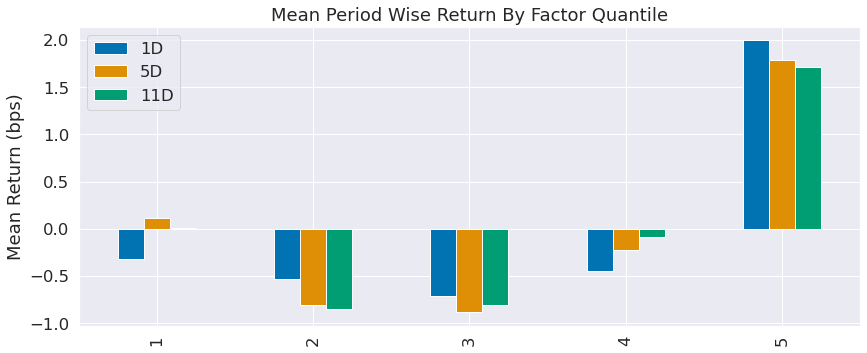

In [94]:
create_summary_tear_sheet(factor_data)